## imports

In [21]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


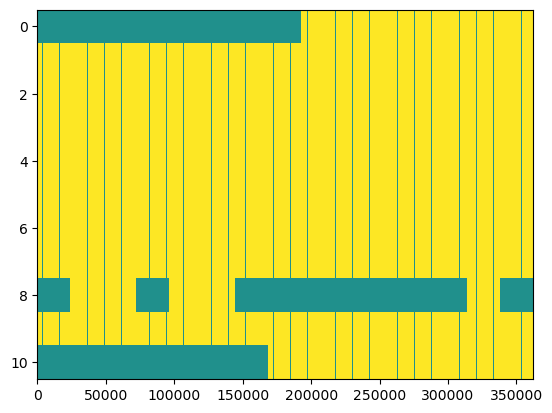

In [5]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

## NIM

In [6]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

Network 0:
  Layer 0:
      weight: torch.Size([360, 8])
  Layer 1:
      weight: torch.Size([8, 11])
      bias: torch.Size([11])


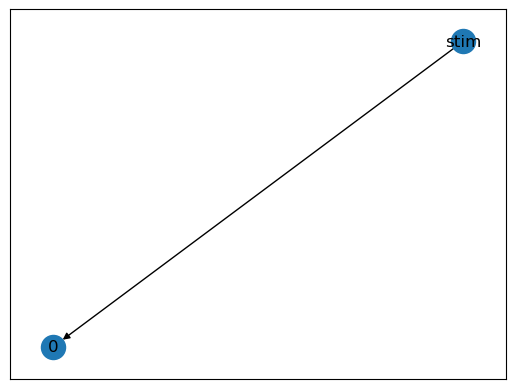

In [46]:
## Shared NIM
num_subs = 8
XTreg0 = 0.1
L1reg0 = 0.0001
Greg = 0.001

# subunit layer
sub_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, 
    norm_type=0,
    NLtype='softplus', 
    bias=True, 
    initialize_center = True)

nim_all = NDN.NDN( layer_list=[sub_par, readout_par] )

m.draw_model(nim_all)

nim_all.list_parameters()

In [49]:
# nim_all.fit(data, **adam_pars, verbose=2)
# LLs1 = nim_all.eval_models(data[data.val_inds], null_adjusted=True)
# print(LLs1)
# print(np.mean(LLs1))
# 
# import pickle
# with open('nim1.pickle', 'wb') as f:
#    pickle.dump(nim_all, f)

Model: M011_NN

GPU Available: True, GPU Used: True


Validating ver=11: 100%|██████████████████████████████████████████████████| 35/35 [00:01<00:00, 20.07it/s, val_loss=4.63]


Early stopping
Done fitting
  Fit complete: 63.621477127075195 sec elapsed
[0.39428353 0.53424156 1.1560173  0.2719097  0.4353925  0.02422976
 0.13895082 0.2598815  0.01284218 0.24386096 0.17018747]
0.33107248


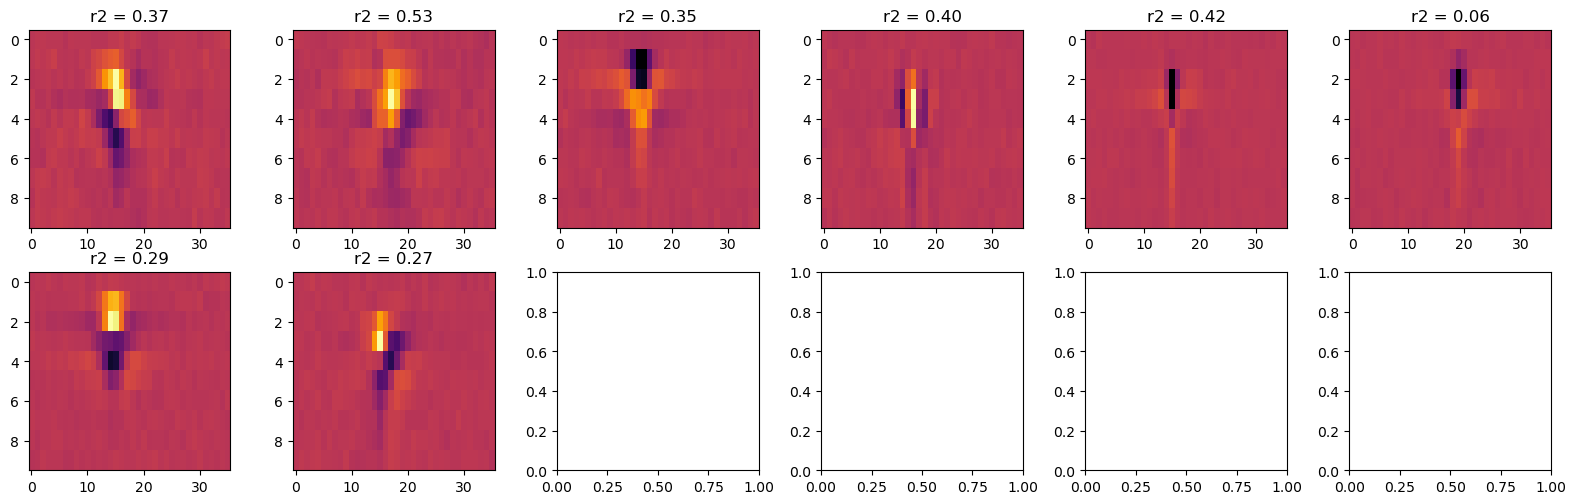

In [54]:
glm_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim_all)]

# plot GLM filters
ss(2, 6)
for c in range(8):
    plt.subplot(2, 6, c+1)
    imagesc(nim_all.networks[0].layers[0].get_weights()[:,:,c], cmap='inferno')
    plt.title('r2 = ' + glm_r2s[c])
plt.show()

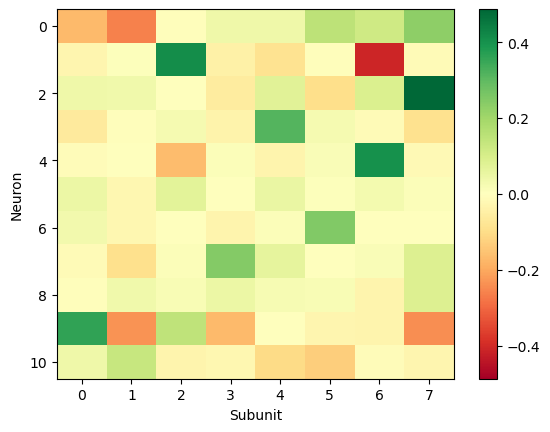

In [51]:
# Readout layer
wR = nim_all.get_weights(layer_target=1)
imagesc(wR, cmap='RdYlGn')
plt.xlabel('Subunit')
plt.ylabel('Neuron')
plt.colorbar()
plt.show()

### plot the filter as the weighted sum of one of the neurons 

In [109]:
hidden = nim_all.networks[0].layers[0].get_weights()
output = nim_all.get_weights(layer_target=1)
hidden.shape, output.shape

((36, 10, 8), (8, 11))

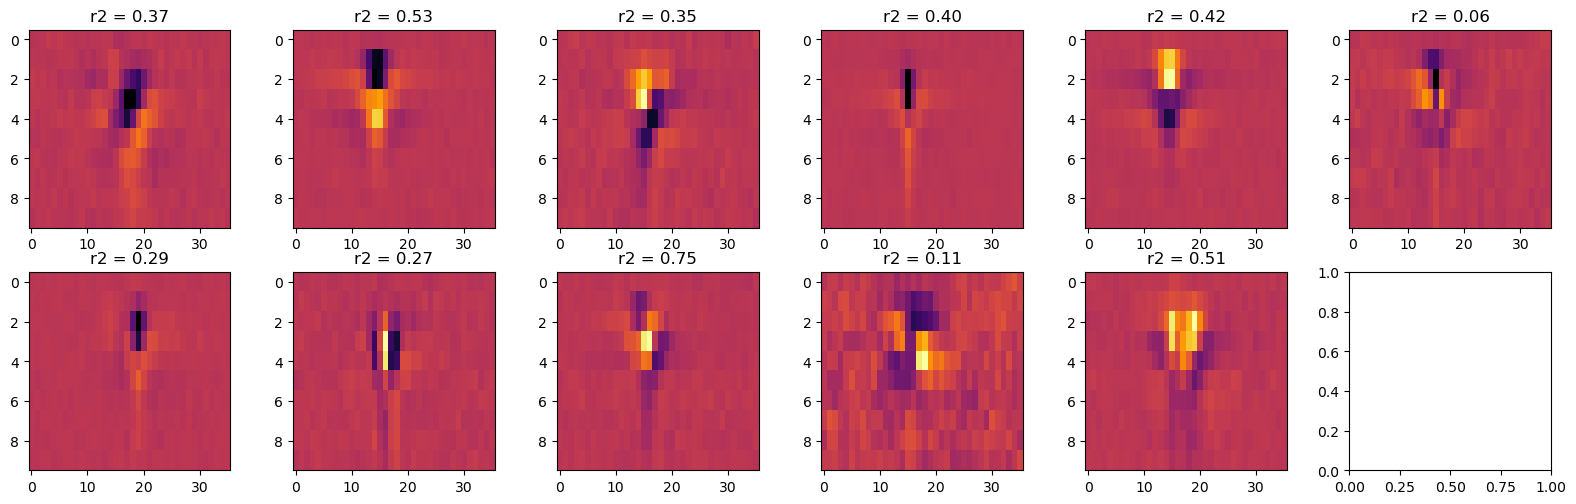

In [111]:
nim_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim_all)]

# plot cell weighted filters
ss(2, 6)
for c in range(11):
    plt.subplot(2, 6, c+1)
    rfield = np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T
    imin = -np.max(abs(rfield))
    imax = np.max(abs(rfield))
    plt.imshow(rfield, cmap='inferno', aspect='auto', vmin=imin, vmax=imax)
    plt.title('r2 = ' + nim_r2s[c])
plt.show()

### all data on GPU

In [10]:
## If there is enough memory on the device, can put the whole dataloader on the GPU
#del train_ds , val_ds
torch.cuda.empty_cache()

data.set_cells()
train_ds = GenericDataset(data[data.train_inds], device=device)
val_ds = GenericDataset(data[data.val_inds], device=device)

  Reset cells_out to full dataset (11 cells).


In [11]:
## About 2x speedup
nim_all = NDN.NDN( layer_list=[sub_par, readout_par])
nim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
LLs1 = nim_all.eval_models(val_ds, null_adjusted=True)
print(LLs1, np.mean(LLs1))


GPU Available: True, GPU Used: True


Validating ver=7: 100%|███████████████████████████████████████████████████| 35/35 [00:00<00:00, 67.31it/s, val_loss=0.43]


Early stopping
Done fitting
  Fit complete: 98.38237857818604 sec elapsed


Eval models: 100%|██████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 139.23it/s]

[ 0.5282929   0.5377948   1.0621192   0.25477898  0.38174248 -0.00737143
  0.04663265 -0.0664115  -0.09713602  0.36019015  0.25659966] 0.29611203


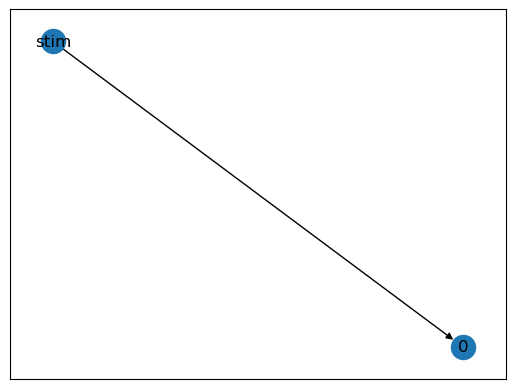

In [20]:
m.draw_model(nim_all)

In [16]:
nim_all.networks[0].layers[0](data.stim).shape

torch.Size([362504, 11])

<Figure size 640x480 with 0 Axes>

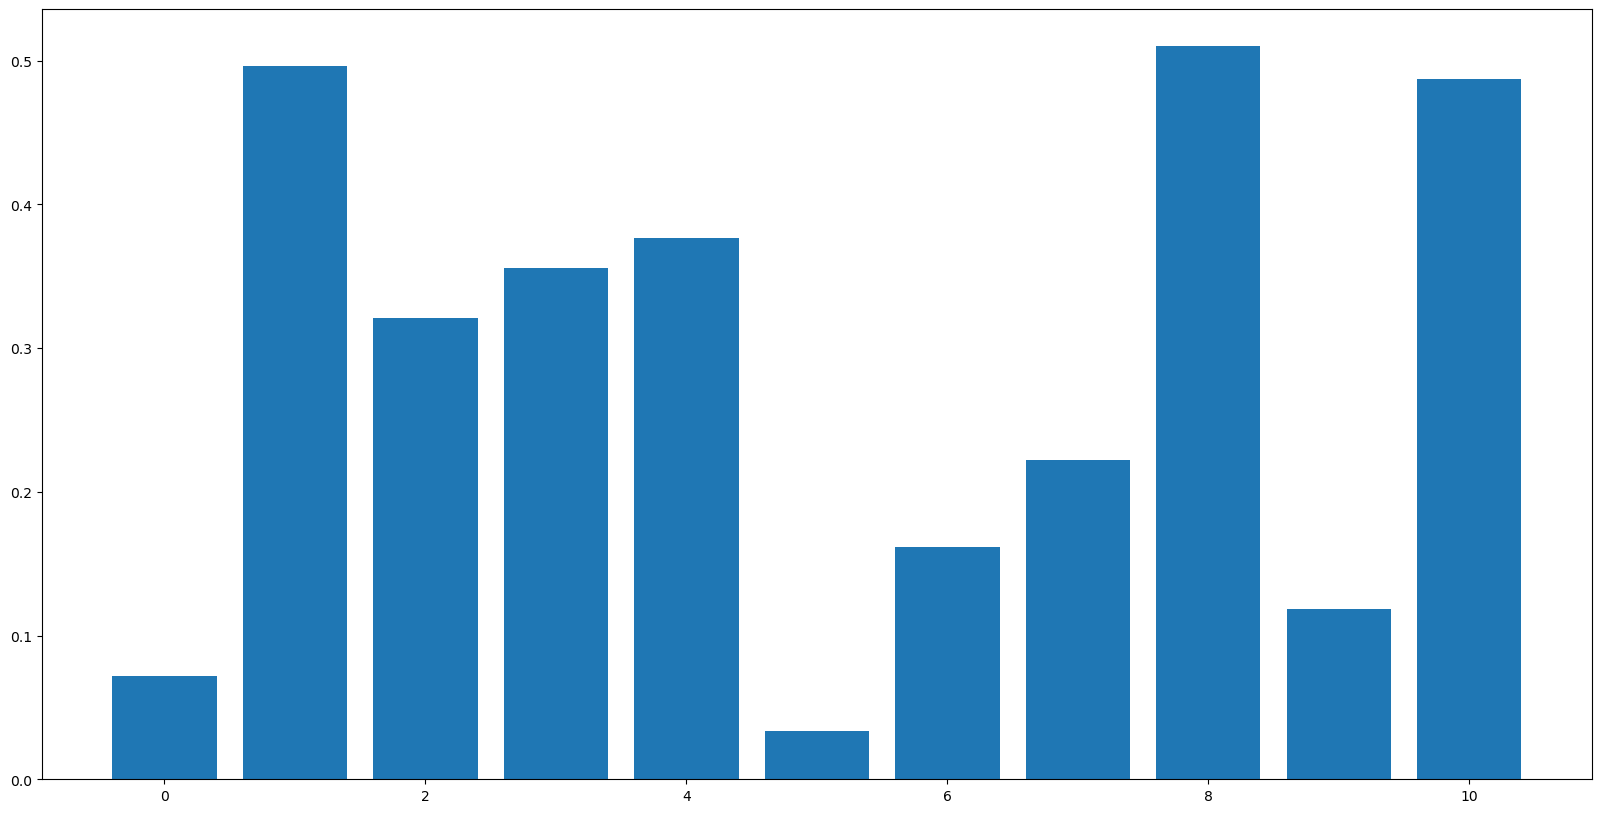

In [28]:
# R2
m.fig()
plt.bar(range(11), met.r2(data, nim_all))
plt.show()

## CNIM

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([288, 11])
      bias: torch.Size([11])


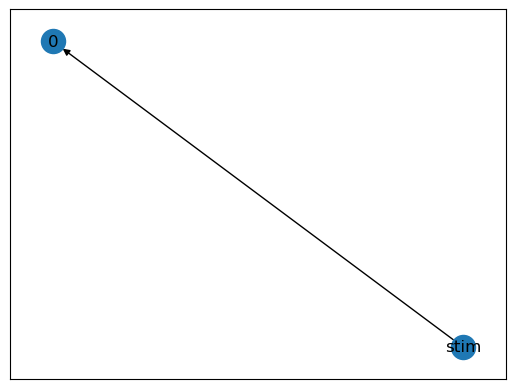

In [73]:
num_subs = 8
fw = 21
XTreg0 = 0.01
L1reg0 = 0.0001
Greg = 0.001
# subunit layer
csub_par = ConvLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=num_subs,
    norm_type=1,
    num_inh=num_subs//2, # this specifies that the first half of the subunits should be inhibitory (use "flipped" ReLU nonlinearity)
    filter_dims=fw, # dimensions of the Convolutional filter
    window='hamming', # apply a Hamming window to the filters to avoid edge artifacts 
    NLtype='relu',
    bias=False,
    initialize_center = True)
csub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'center':Greg, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC,
    norm_type=0,
    NLtype='softplus',
    bias=True, # b/c it is the last layer
    pos_constraint=True, # this removes negative values created from the inhibitory subunits from the output
    initialize_center = True)

readout_par['reg_vals'] = {'glocalx': Greg  }
cnim_all = NDN.NDN( layer_list=[csub_par, readout_par] )
cnim_all.list_parameters()

m.draw_model(cnim_all)

In [75]:
# cnim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
# LLs1 = cnim_all.eval_models(val_ds, null_adjusted=True)
# print(LLs1, np.mean(LLs1))
# 
# import pickle
# with open('cnim1.pickle', 'wb') as f:
#    pickle.dump(cnim_all, f)


GPU Available: True, GPU Used: True


Validating ver=3: 100%|██████████████████████████████████████████████████| 35/35 [00:00<00:00, 66.18it/s, val_loss=0.421]


Early stopping
Done fitting
  Fit complete: 37.828874588012695 sec elapsed


Eval models: 100%|██████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 104.49it/s]

[ 1.82872295e-01  5.92794180e-01  9.22882318e-01  2.63538122e-01
  4.00677323e-01  1.04685545e-01  1.18107796e-01  2.93750763e-02
 -5.72204590e-06  4.75957155e-01  1.05006695e-01] 0.2905355


In [78]:
cnim_all.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([288, 11])
      bias: torch.Size([11])


### plot convolutional filters

In [100]:
cnim_all.networks[0].layers[1].output_dims, cnim_all.networks[0].layers[1]._output_dims

([11, 1, 1, 1], [11, 1, 1, 1])

In [112]:
# get the convolutional filters
hidden = cnim_all.networks[0].layers[0].get_weights()
output = cnim_all.networks[0].layers[1].get_weights()
data.stim_dims, '-->', hidden.shape, '-->', output.shape

([1, 36, 1, 10], '-->', (21, 10, 8), '-->', (8, 36, 11))

In [107]:
cnim_all.networks[0].layers

ModuleList(
  (0): ConvLayer(
    (NL): ReLU()
    (reg): Regularization(
      (reg_modules): ModuleList(
        (0): ConvReg()
        (1): InlineReg()
        (2): DiagonalReg()
      )
    )
  )
  (1): NDNLayer(
    (NL): Softplus(beta=1, threshold=20)
    (reg): Regularization(
      (reg_modules): ModuleList(
        (0): LocalityReg()
      )
    )
  )
)

In [ ]:
# https://theaisummer.com/receptive-field/
# https://distill.pub/2019/computing-receptive-fields/
# Article for how to calculate the receptive field of a CNN

# sum over the filters horizontally,
# so that we have 10 x 36 coming out of the first layer
# and 

ValueError: cannot reshape array of size 1680 into shape (360,8)

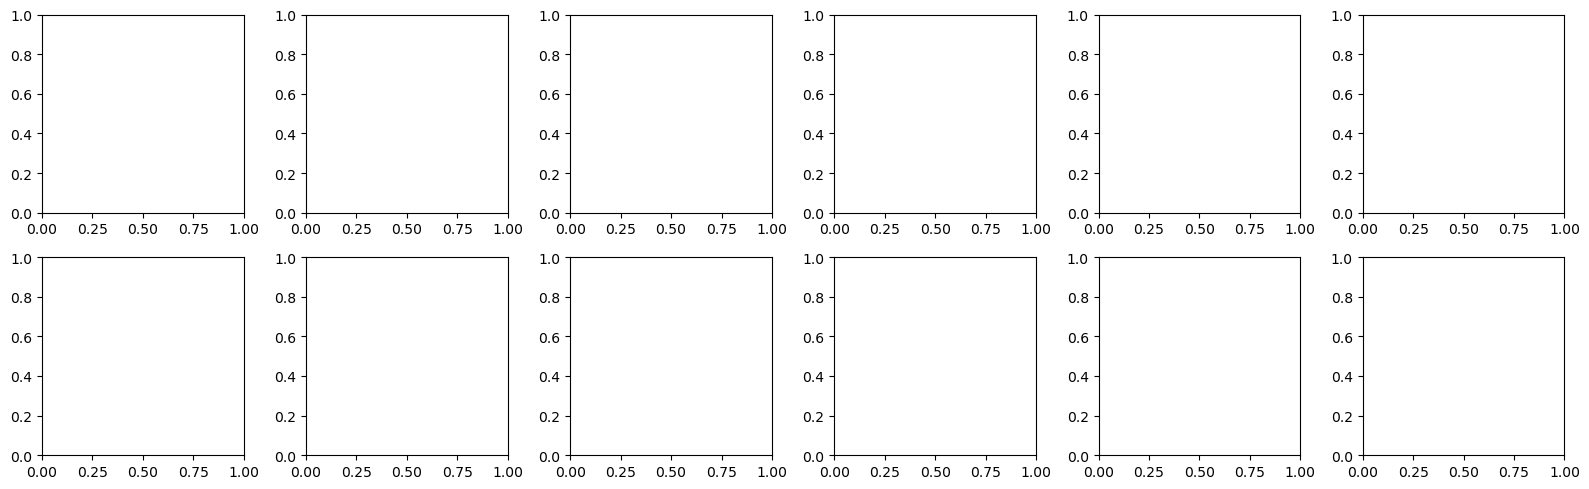

In [77]:
cnim_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim_all)]

# plot cell weighted filters
ss(2, 6)
for c in range(11):
    plt.subplot(2, 6, c+1)
    plt.imshow(np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T, cmap='inferno', aspect='auto')
    plt.title('r2 = ' + cnim_r2s[c])
plt.show()

## excitation/inhibition

(8, 36, 11)


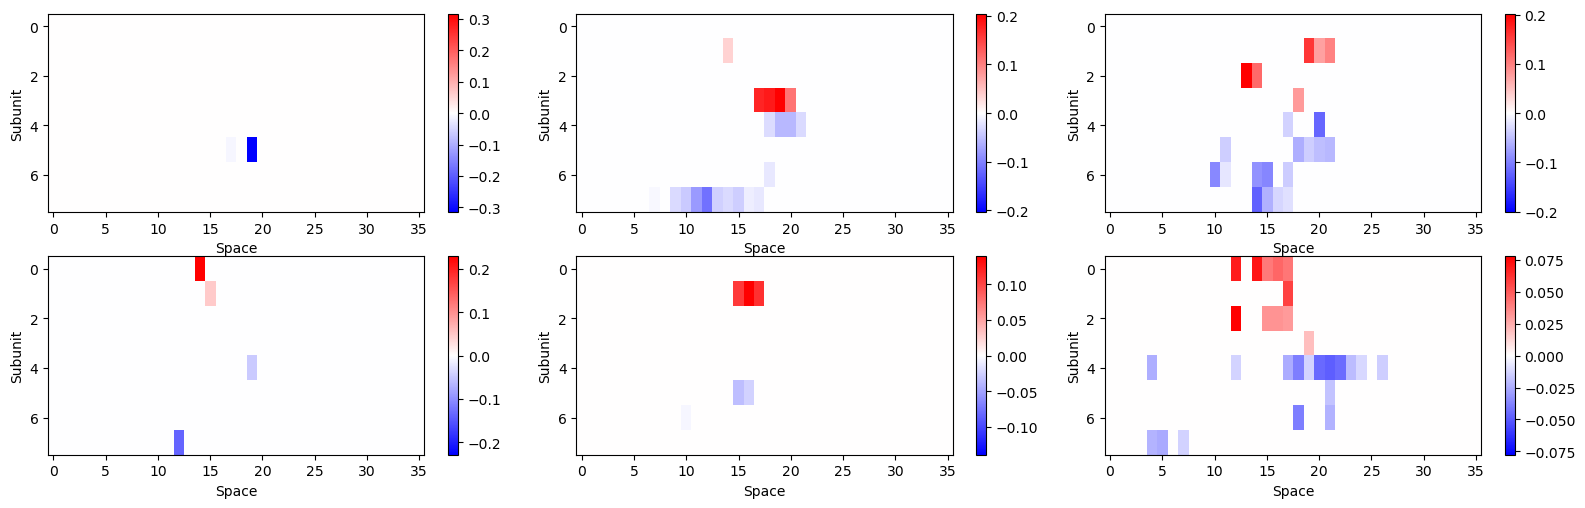

In [97]:
# Readout layer
wR = cnim_all.get_weights(layer_target=1)
print(wR.shape)
wR[num_subs//2:, :] *= -1 # Make inhibitory weights less than zero
num_col = np.minimum(data.NC, 6)
ss(2, num_col//2)
for cc in range(num_col):
    plt.subplot(2, num_col//2, cc+1)
    imagesc(wR[:,:,cc].T, cmap='bwr')
    plt.ylabel('Subunit')
    plt.xlabel('Space')
    plt.colorbar()
plt.show()

<Figure size 640x480 with 0 Axes>

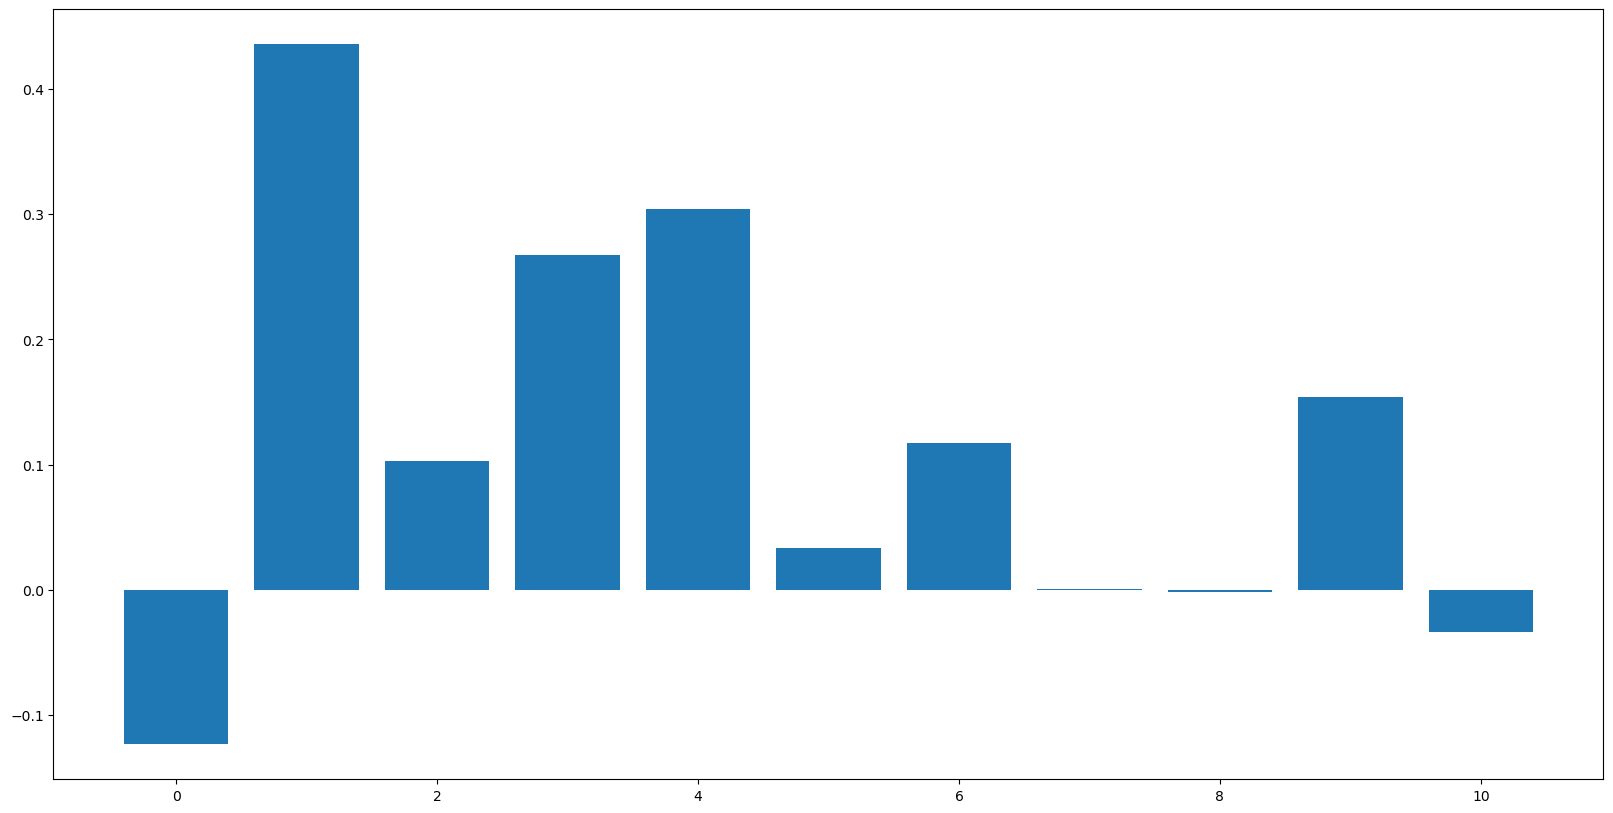

In [27]:
# R2
m.fig()
plt.bar(range(11), met.r2(data, cnim_all))
plt.show()